In [ ]:
#default_exp core.models

In [ ]:
#export
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import copy
from cult.config import DATA_PATH
from cult.core.utils import rec_likelihood, kl_div_stdnorm, disable_gradient, enable_gradient

In [ ]:
#hide
from cult.core.datasets.moving_mnist import MovingMNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Models
> Pytorch Models used for encoders, decoders, and classifiers.

In [ ]:
#hide 
from cult.core.datasets.moving_mnist import MovingMNIST, CommonMNIST

In [ ]:
#hide
batch_size = 128
latents = 24
max_environments = 30
moving_mnist = MovingMNIST(DATA_PATH, transform=ToTensor())
mnist = CommonMNIST(DATA_PATH, transform=ToTensor())
mm_loader = DataLoader(moving_mnist, batch_size)
mnist_loader = DataLoader(mnist, batch_size)

mm_batch, _, _= iter(mm_loader).next()
mnist_batch, _ = iter(mnist_loader).next()

## Encoders


In [ ]:
#export
class Encoder(nn.Module):
    def __init__(self, latents=10, device='cpu'):
        super().__init__()
        self.latents = latents
        self.conv1 = nn.Conv2d(1, 64, (4,4), stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 64, (4,4), 2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, (4,4), 2, padding=1)
        self.conv4 = nn.Conv2d(128, 128, (4,4), 2, padding=1)
        self.linear = nn.Linear(2048, 256)
        self.linear_mu = nn.Linear(256, self.latents)
        self.linear_logvar = nn.Linear(256, self.latents)
        self.relu = nn.ReLU()
        self.device = device

    def forward(self, x):
        """
        Returns mean and standard deviation to parameterize sigmoid, 
        and final layer to compute environment
        """
        x = self.relu(self.conv1(x)) # (batch_size, 64, 32, 32)
        x = self.relu(self.conv2(x)) # (batch_size, 64, 16, 16)
        x = self.relu(self.conv3(x)) # (batch_size, 128, 8, 8)
        x = self.relu(self.conv4(x)) # (batch_size, 128, 4, 4)
        x = x.reshape(-1, 2048)
        final = self.relu(self.linear(x))
        mu = self.linear_mu(final)
        logvar = self.linear_logvar(final)
        return mu, logvar, final.detach() #detach to prevent gradient flow

In [ ]:
encoder = Encoder(latents=latents)

In [ ]:
mu, sigma, final = encoder(mm_batch)

In [ ]:
assert mu.shape == torch.Size((batch_size, latents))
assert sigma.shape == torch.Size((batch_size, latents))

### FC Encoder

In [ ]:
#export
class FCEncoder(nn.Module):
    def __init__(self, latents: int, device='cpu'):
        super().__init__()
        self.latents = latents
        self.latents = latents
        self.linear1 = nn.Linear(784, 50)
        self.linear_mu = nn.Linear(50, latents)
        self.linear_logvar = nn.Linear(50, latents)
        self.act = nn.ReLU()
        self.device = device
    
    def forward(self, x):
        x = x.reshape(-1, 784)
        final = self.act(self.linear1(x))
        mu = self.linear_mu(final)
        logvar = self.linear_logvar(final) #TODO: should this be exponentiated?
        return mu, logvar, final

In [ ]:
fc_encoder = FCEncoder(latents=latents)

In [ ]:
mu, sigma, final = fc_encoder(mnist_batch)

In [ ]:
assert mu.shape == torch.Size((batch_size, latents))
assert sigma.shape == torch.Size((batch_size, latents))

### CNN Encoder

In [ ]:
#export
class CNNEncoder(nn.Module):
    def __init__(self, latents: int, device='cpu'):
        super().__init__()
        self.latents = latents
        self.conv1 = nn.Conv2d(1, 32, (4,4), stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 32, (4,4), 2, padding=0)
        self.conv3 = nn.Conv2d(32, 64, (4,4), 2, padding=0)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(256, 64)
        self.linear_mu = nn.Linear(64, latents)
        self.linear_logvar = nn.Linear(64, latents)
        self.act = nn.ReLU()
        self.device = device
    
    def forward(self, x):
        x = self.act(self.conv1(x))
        x = self.act(self.conv2(x))
        x = self.act(self.conv3(x))
        #x = self.act(self.conv4(x))
        x = self.flatten(x)
        final = self.act(self.linear1(x))
        mu = self.linear_mu(final)
        logvar = self.linear_logvar(final) #TODO: should this be exponentiated?
        return mu, logvar, final

In [ ]:
cnn_encoder = CNNEncoder(latents=latents)
mu, sigma, final = cnn_encoder(mnist_batch)

In [ ]:
assert mu.shape == torch.Size((batch_size, latents))
assert sigma.shape == torch.Size((batch_size, latents))

## Environmental Inference Network

In [ ]:
#export
class EnvironmentInference(nn.Module):
    def __init__(self, max_environmnets: int, input_dim:int, hidden_dim=50):
        super().__init__()
        self.max_environments = max_environmnets
        self.input_dim = input_dim
        self.linear = nn.Linear(input_dim, self.max_environments)
        self.dropout = nn.Dropout(p=.5)
        self.softmax = nn.Softmax(dim=1)
        self.relu = nn.ReLU()
    
    def forward(self, final_latent):
        x = self.linear(final_latent)
        x = self.dropout(x)
        return self.softmax(x)

In [ ]:
_, _, final = encoder(mm_batch)

In [ ]:
env_inf = EnvironmentInference(max_environmnets=max_environments, input_dim=256)
env_dist = env_inf(final)

In [ ]:
assert env_dist.shape == torch.Size([batch_size, max_environments])

In [ ]:
env_dist.sum(dim=1).shape

torch.Size([128])

In [ ]:
assert torch.all(torch.isclose(env_dist.sum(dim=1), torch.ones(128)))

### Environmental  Encoding

In [ ]:
avg_env_dist = env_dist.mean(dim=0)

In [ ]:
assert avg_env_dist.shape == torch.Size((max_environments,))

In [ ]:
env_idx = torch.argmax(avg_env_dist)
env_idx

tensor(29)

In [ ]:
F.one_hot(env_idx, num_classes=max_environments)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1])

In [ ]:
#export
def env_dist_to_idx(env_dist: torch.Tensor, max_environments: int) -> torch.Tensor:
    """Converts a batch of distributions to a one-hot vector"""
    batch_size = env_dist.shape[0]
    avg_env_dist = env_dist.mean(dim=0)
    env_idx = torch.argmax(avg_env_dist)
    return torch.ones((batch_size), dtype=torch.int64) * env_idx


In [ ]:
_, _, final = encoder(mm_batch)
env_dist = env_inf(final)
env_idx = env_dist_to_idx(env_dist, max_environments=max_environments)

In [ ]:
assert env_idx.shape == torch.Size([batch_size])
assert env_idx[0].dtype == torch.int64

## Decoder

### Decoder Architecture From Paper

In [ ]:
#export
class Decoder(nn.Module):
    def __init__(self, latents:int, max_envs=0, device='cpu'):
        super().__init__()
        self.max_envs = max_envs
        self.latents = latents
        self.linear2 = nn.Linear(latents + max_envs, 256)
        self.linear1 = nn.Linear(256, 2048)
        self.conv4 = nn.ConvTranspose2d(128, 128, (4,4), 2, padding=1)
        self.conv3 = nn.ConvTranspose2d(128, 64, (4,4), 2, padding=1)
        self.conv2 = nn.ConvTranspose2d(64, 64, (4,4), 2, padding=1)
        self.conv1 = nn.ConvTranspose2d(64, 1, (4,4), 2, padding=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.device = device
        
    def forward(self, z, s=None):
        """
        Decode the latent and environmental variables

        Args: 
            z (Tensor): latent variables
            s (Tensor): environment indicies (not one hot)
        
        Returns:
            Means for (batchsize, widgt, height) Bernoulli's (which can be interpreted as the reconstructed image)
        """
        
        if s is not None:
            s_one_hot = F.one_hot(s, num_classes=self.max_envs).to(self.device)
            z = torch.cat((z, s_one_hot), dim=1)
        x = self.relu(self.linear2(z)) # (batch_size, 256)
        x = self.relu(self.linear1(x)) # (batch_size, 512)
        x = x.reshape(-1, 128, 4, 4) # (batch_size, 128, 2, 2)
        x = self.relu(self.conv4(x)) # (batch_size, 128, 6, 6)
        x = self.relu(self.conv3(x)) # (batch_size, 64, 14, 14)
        x = self.relu(self.conv2(x)) # (batch_size, 64, 30, 30) WRONG (should be 31)
        out = self.sigmoid(self.conv1(x))
        return out

In [ ]:
mu, sigma, final = encoder(mm_batch)
env_dist = env_inf(final)
env_idx = env_dist_to_idx(env_dist, max_environments=max_environments)
z = mu
s = env_idx

In [ ]:
decoder = Decoder(latents=latents, max_envs=max_environments)

In [ ]:
rec_img = decoder(z, s)

In [ ]:
rec_img.shape

torch.Size([128, 1, 64, 64])

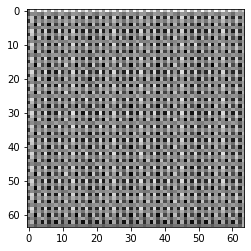

In [ ]:
plt.imshow(rec_img[0].detach().numpy().squeeze(), cmap='gray')

In [ ]:
decoder = Decoder(latents=latents, max_envs=0)

In [ ]:
rec_img = decoder(z, None)

In [ ]:
assert rec_img.shape == torch.Size([batch_size, 1, 64, 64])

### FC Decoder

In [ ]:
#export
class FCDecoder(nn.Module):
    def __init__(self, latents: int, max_envs=0, device='cpu'):
        super().__init__()
        self.max_envs = max_envs
        self.latents = latents
        self.linear1 = nn.Linear(latents + max_envs, 50)
        self.linear2 = nn.Linear(50, 784)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.device = device
        
    def forward(self, z, s=None):
        """
        Decode the latent and environmental variables

        Args: 
            z (Tensor): latent variables
            s (Tensor): one-hot encoded environmental variable (not sure how this works...)
        
        Returns:
            Means for (batchsize, widgt, height) Bernoulli's (which can be interpreted as the reconstructed image)
        """
        if s is not None:
            s_one_hot = F.one_hot(s, num_classes=self.max_envs).to(self.device)
            z = torch.cat((z, s_one_hot), dim=1)
        x = self.relu(self.linear1(z))
        x = self.linear2(x)
        out = self.sigmoid(x)
        out = out.reshape(-1, 1, 28, 28)
        return out

In [ ]:
mu, sigma, final = fc_encoder(mnist_batch)
env_inf = EnvironmentInference(max_environmnets=max_environments, input_dim=50)
env_dist = env_inf(final)
env_idx = env_dist_to_idx(env_dist, max_environments=max_environments)
z = mu
s = env_idx

In [ ]:
fc_decoder = FCDecoder(latents=latents, max_envs=max_environments)

In [ ]:
rec_img = fc_decoder(z, s)

In [ ]:
rec_img.shape

torch.Size([128, 1, 28, 28])

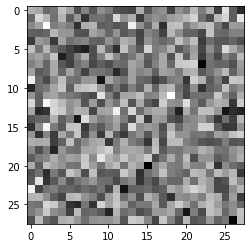

In [ ]:
plt.imshow(rec_img[0].detach().numpy().squeeze(), cmap='gray')

In [ ]:
fc_decoder = FCDecoder(max_envs=0, latents=latents)

In [ ]:
rec_img = fc_decoder(z, None)

In [ ]:
assert rec_img.shape == mnist_batch.shape

### CNN Decoder

In [ ]:
#export
class CNNDecoder(nn.Module):
    def __init__(self, latents: int, max_envs=0, device='cpu'):
        super().__init__()
        self.max_envs = max_envs
        self.latents = latents
        self.linear1 = nn.Linear(latents + max_envs, 64)
        self.linear2 = nn.Linear(64, 256)
        self.conv1 = nn.ConvTranspose2d(64, 32, (4,4), 2)
        self.conv2 = nn.ConvTranspose2d(32, 32, (4,4), 2)
        self.conv3 = nn.ConvTranspose2d(32, 1, (4,4), 2, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.device = device
        
    def forward(self, z, s=None):
        """
        Decode the latent and environmental variables

        Args: 
            z (Tensor): latent variables
            s (Tensor): one-hot encoded environmental variable (not sure how this works...)
        
        Returns:
            Means for (batchsize, widgt, height) Bernoulli's (which can be interpreted as the reconstructed image)
        """
        if s is not None:
            s_one_hot = F.one_hot(s, num_classes=self.max_envs).to(self.device)
            z = torch.cat((z, s_one_hot), dim=1)
        x = self.relu(self.linear1(z))
        x = self.relu(self.linear2(x))
        x = x.reshape(-1, 64, 2, 2)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        out = self.sigmoid(x)
        return out

In [ ]:
mu, sigma, final = cnn_encoder(mnist_batch)
env_inf = EnvironmentInference(max_environmnets=max_environments, input_dim=64)
env_dist = env_inf(final)
env_idx = env_dist_to_idx(env_dist, max_environments=max_environments)
z = mu
s = env_idx

In [ ]:
cnn_decoder = CNNDecoder(latents=latents)

In [ ]:
rec_x = cnn_decoder(z, None)

In [ ]:
rec_x.shape

torch.Size([128, 1, 28, 28])

In [ ]:
assert rec_x.shape == mnist_batch.shape

## Vanilla VAEs

### Reparameterization Trick


In [ ]:
#export
def reparam(mu, logvar, device='cpu'):
    eps = torch.randn(logvar.shape).to(device)
    std = (0.5 * logvar).exp()
    return mu + std * eps

### Vanilla VAE (From Paper)

In [ ]:
#export
class VanillaVAE(nn.Module):
    def __init__(self, encoder: type, decoder: type, latents: int, device: str):
        super().__init__()
        self.encoder = encoder(latents=latents)
        self.decoder = decoder(latents=latents)
        self.device = device
        
    def forward(self, x):
        mu, logvar, _final = self.encoder(x)
        if self.training:
            z = reparam(mu, logvar, device=self.device)
        else:
            z = mu
        rec_img = self.decoder(z=z)
        return rec_img, mu, logvar

In [ ]:
#export
class CNNVanillaVAE(VanillaVAE):
    def __init__(self, latents: int, device:str):
        super().__init__(encoder=Encoder, decoder=Decoder, latents=latents, device=device)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
vvae = CNNVanillaVAE(latents=latents, device=device)

In [ ]:
rec_img, mu, logvar = vvae(mm_batch)

In [ ]:
vvae.decoder

Decoder(
  (linear2): Linear(in_features=24, out_features=256, bias=True)
  (linear1): Linear(in_features=256, out_features=2048, bias=True)
  (conv4): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv1): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [ ]:
rec_img.shape

torch.Size([128, 1, 64, 64])

In [ ]:
assert rec_img.shape == mm_batch.shape

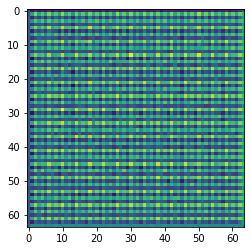

In [ ]:
plt.imshow(rec_img[0].detach().numpy().squeeze())

In [ ]:
assert mu.shape == torch.Size([batch_size, latents])
assert logvar.shape == torch.Size([batch_size, latents])

In [ ]:
vvae.eval()


CNNVanillaVAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (linear): Linear(in_features=2048, out_features=256, bias=True)
    (linear_mu): Linear(in_features=256, out_features=24, bias=True)
    (linear_logvar): Linear(in_features=256, out_features=24, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (linear2): Linear(in_features=24, out_features=256, bias=True)
    (linear1): Linear(in_features=256, out_features=2048, bias=True)
    (conv4): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), pad

In [ ]:
assert not vvae.training

In [ ]:
rec_img, mu, logvar = vvae(mm_batch)

In [ ]:
rec_img_decode = vvae.decoder(mu)

In [ ]:
assert torch.equal(rec_img, rec_img_decode)

### FC Vanilla VAE

In [ ]:
#export
class FCVAE(VanillaVAE):
    def __init__(self, latents: int, device='cpu'):
        super().__init__(encoder=FCEncoder, decoder=FCDecoder, latents=latents, device=device)
        

In [ ]:
fc_vae = FCVAE(latents=latents)

In [ ]:
rec_img, _, _ = fc_vae(mnist_batch)

In [ ]:
assert rec_img.shape == mnist_batch.shape